<h3> World Cup Match Predictor Algorithm/Program </h3>

By AJ Iglesias

In [44]:
#Data analysis and cleaning
import pandas as pd
import numpy as np
#Incase for ensured pathing
import sys
#Web Scraping
import bs4
from bs4 import BeautifulSoup
import requests

#Visuals
import matplotlib.pyplot as plt

#Modeling
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#Simulation
from itertools import combinations

In [45]:
#Begin with world Cup analysis to see how well it can predict games 
#IMPORT RANKINGS FROM FIFA.com
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 'two_year_ago_weighted', 'three_year_ago_weighted']]

rankings = rankings.replace({'IR Iran': 'Iran'})
rankings['weighted_points'] = rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

#IMPORT RESULTS
results = pd.read_csv('int_results.csv')
results = results.replace({'Germany DR': 'Germany', 'China': 'China PR'})
results['date'] = pd.to_datetime(results['date'])

In [46]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [47]:
#Get everyday ranking
rankings = rankings.set_index(['rank_date']).groupby(['country_full'], group_keys = False).resample('D').first().fillna(method = 'ffill').reset_index()

#Merge rankings with results
results = results.merge(rankings, left_on = ['date', 'home_team'], right_on = ['rank_date', 'country_full'])
results = results.merge(rankings, left_on = ['date', 'away_team'], right_on = ['rank_date', 'country_full'], suffixes = ('_Home', '_Away'))

In [48]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_Home,...,three_year_ago_weighted_Home,weighted_points_Home,rank_date_Away,rank_Away,country_full_Away,country_abrv_Away,cur_year_avg_weighted_Away,two_year_ago_weighted_Away,three_year_ago_weighted_Away,weighted_points_Away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0.00,0.00,1993-08-08,22.0,Uruguay,URU,0.00,0.00,0.00,0.00
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,...,0.00,0.00,1993-08-08,14.0,Mexico,MEX,0.00,0.00,0.00,0.00
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0.00,0.00,1993-08-08,94.0,Venezuela,VEN,0.00,0.00,0.00,0.00
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,...,0.00,0.00,1993-08-08,86.0,Sierra Leone,SLE,0.00,0.00,0.00,0.00
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0.00,0.00,1993-08-08,5.0,Argentina,ARG,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17735,2018-06-07,England,Costa Rica,2,0,Friendly,Leeds,England,False,2018-06-07,...,103.52,754.09,2018-06-07,23.0,Costa Rica,CRC,410.90,99.73,133.11,643.74
17736,2018-06-07,Uruguay,Uzbekistan,3,0,Friendly,Montevideo,Uruguay,False,2018-06-07,...,119.85,774.57,2018-06-07,95.0,Uzbekistan,UZB,66.85,93.52,40.74,201.11
17737,2018-06-07,Portugal,Algeria,3,0,Friendly,Lisbon,Portugal,False,2018-06-07,...,125.53,927.78,2018-06-07,66.0,Algeria,ALG,163.41,91.40,101.63,356.44
17738,2018-06-07,Iceland,Ghana,2,2,Friendly,Reykjavík,Iceland,False,2018-06-07,...,96.64,625.89,2018-06-07,47.0,Ghana,GHA,261.21,99.90,92.63,453.74


<h3> Now let's do some feature engineering/generation </h3>

In [49]:
results['rank_diff'] = results['rank_Home'] - results['rank_Away']
results['avg_rank'] = (results['rank_Home'] + results['rank_Home']) / 2
results['point_diff'] = results['weighted_points_Home'] - results['weighted_points_Away']
results['score_diff'] = results['home_score'] - results['away_score']
results['match_win'] = results['score_diff'] > 0 #still undecided on how I want to count draws, here I count them as a loss for version 1.0

#Factor in game type
results['meaningful_match'] = results['tournament'] != 'Friendly'

In [50]:
results.isnull().sum()

date                            0
home_team                       0
away_team                       0
home_score                      0
away_score                      0
tournament                      0
city                            0
country                         0
neutral                         0
rank_date_Home                  0
rank_Home                       0
country_full_Home               0
country_abrv_Home               0
cur_year_avg_weighted_Home      0
two_year_ago_weighted_Home      0
three_year_ago_weighted_Home    0
weighted_points_Home            0
rank_date_Away                  0
rank_Away                       0
country_full_Away               0
country_abrv_Away               0
cur_year_avg_weighted_Away      0
two_year_ago_weighted_Away      0
three_year_ago_weighted_Away    0
weighted_points_Away            0
rank_diff                       0
avg_rank                        0
point_diff                      0
score_diff                      0
match_win     

<h3> Build model using simple logistic regression </h3>

Text(0.5, 1.0, 'Performance on Training Set')

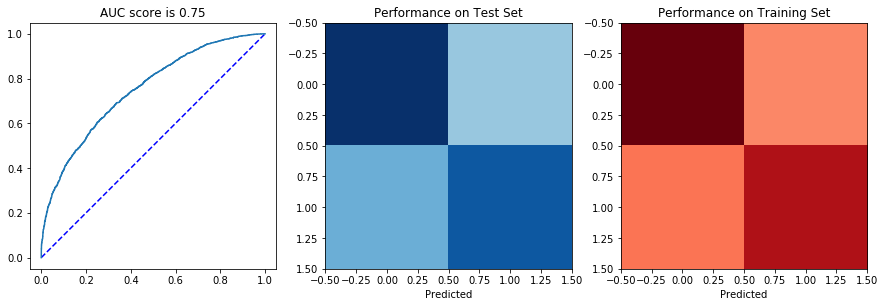

In [51]:
X, y = results.loc[:,['avg_rank', 'rank_diff', 'point_diff', 'meaningful_match']] , results['match_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

lr = linear_model.LogisticRegression(C=0.0001, max_iter = 10000)
features = PolynomialFeatures(degree = 2)

#Model pipeline
model = Pipeline([('polynomial_features', features), ('logistic_regression', lr)])
#Fit model
model = model.fit(X_train, y_train)
#Predicted
yhat = model.predict_proba(X_test)[:,1]

#Results
#fpr = False Positives // tpr = True Positives which helps us get a sensitivity analysis about how well our model performs
fpr, tpr, _ = roc_curve(y_test, yhat)
plt.figure(figsize = (15,10))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'b--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, yhat)))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max()))

ax.set_xlabel('Predicted')
ax.set_title('Performance on Test Set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap = 'Reds', clim = (0, cm.max()))
ax.set_xlabel('Predicted')
ax.set_title('Performance on Training Set')


Let's see these Confusion Matrices values in simplified terms.

Meaningfulness of match distribution in the incorrect predictions
True     0.553819
False    0.446181
Name: meaningful_match, dtype: float64
Meaningful match distribution overall
True     0.621308
False    0.378692
Name: meaningful_match, dtype: float64


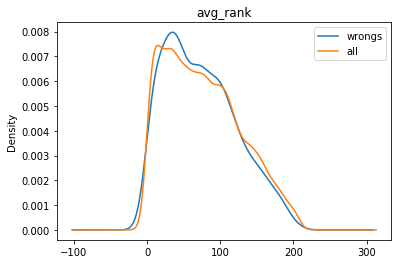

In [52]:
#Let's see how we predict based on avg rank and then see distribution of a meaningful match i.e. NOT A FRIENDLY
features = ['avg_rank']
incorrect = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[incorrect, feature].plot.kde()
    X.loc[:,feature].plot.kde()
    plt.legend(['wrongs', 'all'])

print('Meaningfulness of match distribution in the incorrect predictions')
print(X_test.loc[incorrect, 'meaningful_match'].value_counts() / incorrect.sum())

print('Meaningful match distribution overall')
print(X['meaningful_match'].value_counts() / X.shape[0])

In [53]:
#import world cup data now to simulate group and elimination stages and clean it up a bit
world_cup_df = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup_df = world_cup_df.loc[:, ['Team', 'Group', 'First Match \nagainst', 'Second Match \nagainst', 'Third Match \nagainst']]
world_cup_df = world_cup_df.dropna(how = 'all')
world_cup_df = world_cup_df.replace({'IRAN' : 'Iran', 'Costarica': 'Costa Rica', 'Porugal': 'Portugal',
                                    'Columbia': 'Colombia', 'Korea' : 'Korea Republic'})

world_cup_df = world_cup_df.set_index('Team')

#Selecting a small margin may predict more wins than draws but initialized as 0.05
margin = 0.05

#Define rankings based on time of World Cup for most sense if we wanted to predict the outcome of 2018 World CUp
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & rankings['country_full'].isin(world_cup_df.index.unique())]

world_cup_rankings = world_cup_rankings.set_index(['country_full'])

/Users/ajiglesias/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


<h3> Simulating Group Stages </h3>

In [55]:
#Group stage of World Cup consists of 3 matches where each team either earn 0, 1 or 3 points
opponents = ['First Match \nagainst', 'Second Match \nagainst', 'Third match \nagainst']

world_cup_df['points'] = 0
world_cup_df['total_proba'] = 0

for group in set(world_cup_df['Group']):
    print('---Starting Group {}:---'.format(group))
    for home, away in combinations(world_cup_df.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end = '')
        t_df = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns = X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        
        #Add t_df
        t_df['avg_rank'] = (home_rank + opp_rank) / 2
        t_df['rank_diff'] = home_rank - opp_rank
        t_df['point_diff'] = home_points - opp_points
        
        #Use our logistric model to predict based on our t_df 
        home_wins_proba = model.predict_proba(t_df)[:,1][0]
        world_cup_df.loc[home, 'total_proba'] += home_wins_proba
        world_cup_df.loc[away, 'total_proba'] += 1 - home_wins_proba
        
        #initialize all teams with 0 points
        points = 0
        
        #If 'home' team losses away the opposing team a win and 3 points
        if home_wins_proba <= 0.5 - margin:
            print('{} wins with {:.2f}'.format(away, 1-home_wins_proba))
            print('\n')
            world_cup_df.loc[away, 'points'] += 3
            
        if home_wins_proba > 0.5 - margin:
            points = 1
        
        if home_wins_proba >= 0.5 - margin:
            points = 3
            world_cup_df.loc[home, 'points'] += 3
            print('{} wins with {:.2f}'.format(home, home_wins_proba))
            print('\n')
        
        if points == 1:
            print('Draw')
            world_cup_df.loc[home, 'points'] += 1
            world_cup_df.loc[away, 'points'] += 1

---Starting Group D:---
Argentina vs. Iceland: Argentina wins with 0.56


Argentina vs. Croatia: Argentina wins with 0.55


Argentina vs. Nigeria: Argentina wins with 0.62


Iceland vs. Croatia: Iceland wins with 0.46


Iceland vs. Nigeria: Iceland wins with 0.57


Croatia vs. Nigeria: Croatia wins with 0.58


---Starting Group E:---
Brazil vs. Switzerland: Brazil wins with 0.52


Brazil vs. Costa Rica: Brazil wins with 0.58


Brazil vs. Serbia: Brazil wins with 0.61


Switzerland vs. Costa Rica: Switzerland wins with 0.56


Switzerland vs. Serbia: Switzerland wins with 0.59


Costa Rica vs. Serbia: Costa Rica wins with 0.51


---Starting Group C:---
France vs. Australia: France wins with 0.60


France vs. Peru: France wins with 0.51


France vs. Denmark: France wins with 0.50


Australia vs. Peru: Peru wins with 0.66


Australia vs. Denmark: Denmark wins with 0.68


Peru vs. Denmark: Peru wins with 0.47


---Starting Group H:---
Poland vs. Senegal: Poland wins with 0.56


Poland vs. C

<h3> Elimination Rounds </h3>

In [56]:
#Random order of 16 teams since top 2 make elimination rounds from each group
pairings = [1,5,6,4,11,14,0,2,9,3,12,7,13,8,10,15]

world_cup_df = world_cup_df.sort_values(by = ['Group', 'points', 'total_proba'], ascending = False).reset_index()

elim_rounds_df = world_cup_df.groupby('Group').nth([0,1])
elim_rounds_df = elim_rounds_df.reset_index()
elim_rounds_df = elim_rounds_df.loc[pairings]
elim_rounds_df = elim_rounds_df.set_index('Team')

#Break down World Cup Bracket
rounds = ['Round_of_16', 'Quarterfinal', 'Semifinal', 'Final']

labels = list()
odds = list()

for round_ in rounds:
    print('---Starting of the {}---'.format(round_))
    iterations = int(len(elim_rounds_df) / 2)
    winners = []
    
    for i in range(iterations):
        home = elim_rounds_df.index[i*2]
        away = elim_rounds_df.index[i*2 + 1]
        print('{} vs. {}'.format(home, away), end = '')
        
        t_df = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns = X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        away_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        
        t_df['avg_rank'] = (home_rank - away_rank) / 2
        t_df['rank_diff'] = home_rank - away_rank
        t_df['point_diff'] = home_points - opp_points
        
        #Calculate who wins and depending on the team append them to the winner list for next round
        home_wins_proba = model.predict_proba(t_df)[:,1][0]
        if model.predict_proba(t_df)[:,1] <= 0.5:
            print('. {0} wins with prob. {1:.2f}'.format(away, 1 - home_wins_proba))
            winners.append(away)
        
        else:
            print('. {0} wins with prob. {1:.2f}'.format(home, home_wins_proba))
            winners.append(home)
        
        labels.append('{}({:.2f}) vs. {}({:.2f})'.format(world_cup_rankings.loc[home, 'country_abrv'], 1 / home_wins_proba,
                                                       world_cup_rankings.loc[away, 'country_abrv'], 1 / (1 - home_wins_proba)))
        
        odds.append([home_wins_proba, 1 - home_wins_proba])
    elim_rounds_df = elim_rounds_df.loc[winners]
    print('\n')

---Starting of the Round_of_16---
Egypt vs. Peru. Peru wins with prob. 0.72
Argentina vs. France. Argentina wins with prob. 0.52
Mexico vs. Poland. Poland wins with prob. 0.53
Uruguay vs. Portugal. Portugal wins with prob. 0.57
Switzerland vs. Spain. Switzerland wins with prob. 0.52
Belgium vs. Iceland. Belgium wins with prob. 0.62
England vs. Brazil. Brazil wins with prob. 0.57
Germany vs. Colombia. Germany wins with prob. 0.61


---Starting of the Quarterfinal---
Peru vs. Argentina. Argentina wins with prob. 0.54
Poland vs. Portugal. Portugal wins with prob. 0.55
Switzerland vs. Belgium. Belgium wins with prob. 0.54
Brazil vs. Germany. Germany wins with prob. 0.54


---Starting of the Semifinal---
Argentina vs. Portugal. Portugal wins with prob. 0.52
Belgium vs. Germany. Germany wins with prob. 0.53


---Starting of the Final---
Portugal vs. Germany. Germany wins with prob. 0.54




<h3> Congrats Germany :D </h3>

In [ ]:
#Extra analysis to be done. 
'''
#Import data using BeautifulSoup from Fifa.com for International teams to begin match analysis
web_address = requests.get('https://www.fifaindex.com/teams')
int_df = pd.DataFrame
web_address_1 = 'https://www.fifaindex.com/teams/'

for day in range(1,5,1):
     for pag in range(1,5):
     
        source_address = web_address_1 + '01_' + str(day) + '/' + str(pag) + '/' + '?type=1'
        print('Day:', day)
        print(pag)
        
#Code BELOW WORKS *********************************************
#Let's scrape the data
        try:
            soup = BeautifulSoup(web_address.content, 'html.parser')
            #soup = get_soup(source_address)
            resulting_lst = soup.find('table', {'class': 'table table-striped table-teams'})
    
        except:
            print('Page not found. ')

        date = str(soup.find('ol', {'class': 'breadcrumb'}))

#Load the dataframe if it is empty, which it should be :D
        if int_df.empty:
            int_df = pd.read_html(str(resulting_lst))[0]
            int_df['Date'] = date
        else:
            temp_df = pd.read_html(str(resulting_lst))[0]
            temp_df['Date'] = date
            int_df = int_df.append(temp_df)


#Data we will use in part 2 of this analysis
results = pd.read_csv('premier-league/results.csv')
#stats = pd.read_csv('premier-league/stats.csv')
''''''